<a href="https://colab.research.google.com/github/rkirk29/fastai/blob/main/Giraffe_subspecies_Classifier_02_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 2.2MB/s 
     |████████████████████████████████| 51kB 4.5MB/s 
     |████████████████████████████████| 51kB 3.6MB/s 
     |████████████████████████████████| 194kB 3.6MB/s 
     |████████████████████████████████| 1.0MB 6.5MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 40kB 4.5MB/s 
     |████████████████████████████████| 92kB 5.4MB/s 
     |████████████████████████████████| 61kB 5.0MB/s 
     |████████████████████████████████| 51kB 3.7MB/s 
     |████████████████████████████████| 2.6MB 6.0MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# clean
To download images with Bing Image Search, sign up at Microsoft for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'xxxxxxxxxxxxxxxxx')

In [ ]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('content_url')
len(ims)

150

We've successfully downloaded the URLs of 150 grizzly bears (or, at least, images that Bing Image Search finds for that search term). Let's look at one:

In [7]:
import os
os.mkdir("images")

This seems to have worked nicely, so let's use fastai's `download_images` to download all the URLs for each of our search terms. We'll put each in a separate folder:

In [20]:
giraffe_types = 'nubian','reticulated','masai'
path = Path('giraffes')

In [21]:
if not path.exists():
    path.mkdir()
    for o in giraffe_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} giraffe')
        download_images(dest, urls=results.attrgot('content_url'))

Our folder has image files, as we'd expect:

In [22]:
fns = get_image_files(path)
fns

(#445) [Path('giraffes/masai/00000047.jpg'),Path('giraffes/masai/00000014.jpg'),Path('giraffes/masai/00000015.jpg'),Path('giraffes/masai/00000066.jpg'),Path('giraffes/masai/00000099.jpg'),Path('giraffes/masai/00000129.jpg'),Path('giraffes/masai/00000077.jpg'),Path('giraffes/masai/00000024.jpg'),Path('giraffes/masai/00000083.jpg'),Path('giraffes/masai/00000020.jpg')...]

> j: I just love this about working in Jupyter notebooks! It's so easy to gradually build what I want, and check my work every step of the way. I make a _lot_ of mistakes, so this is really helpful to me...

Often when we download files from the internet, there are a few that are corrupt. Let's check:

In [17]:
??verify_images

In [23]:
failed = verify_images(fns)
failed

(#5) [Path('giraffes/masai/00000021.jpg'),Path('giraffes/masai/00000106.jpg'),Path('giraffes/reticulated/00000045.jpg'),Path('giraffes/reticulated/00000132.jpg'),Path('giraffes/reticulated/00000008.jpg')]

In [24]:
len(failed)

5

To remove all the failed images, you can use `unlink` on each of them. Note that, like most fastai functions that return a collection, `verify_images` returns an object of type `L`, which includes the `map` method. This calls the passed function on each element of the collection:

In [25]:
failed.map(Path.unlink);

## From Data to DataLoaders

`DataLoaders` is a thin class that just stores whatever `DataLoader` objects you pass to it, and makes them available as `train` and `valid`. Although it's a very simple class, it's very important in fastai: it provides the data for your model. The key functionality in `DataLoaders` is provided with just these four lines of code (it has some other minor functionality we'll skip over for now):

```python
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])
```

> jargon: DataLoaders: A fastai class that stores multiple `DataLoader` objects you pass to it, normally a `train` and a `valid`, although it's possible to have as many as you like. The first two are made available as properties.

Later in the book you'll also learn about the `Dataset` and `Datasets` classes, which have the same relationship.

To turn our downloaded data into a `DataLoaders` object we need to tell fastai at least four things:

- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set

So far we have seen a number of *factory methods* for particular combinations of these things, which are convenient when you have an application and data structure that happen to fit into those predefined methods. For when you don't, fastai has an extremely flexible system called the *data block API*. With this API you can fully customize every stage of the creation of your `DataLoaders`. Here is what we need to create a `DataLoaders` for the dataset that we just downloaded:

In [26]:
giraffes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [27]:
dls = giraffes.dataloaders(path)

A `DataLoaders` includes validation and training `DataLoader`s. `DataLoader` is a class that provides batches of a few items at a time to the GPU. We'll be learning a lot more about this class in the next chapter. When you loop through a `DataLoader` fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. We can take a look at a few of those items by calling the `show_batch` method on a `DataLoader`:

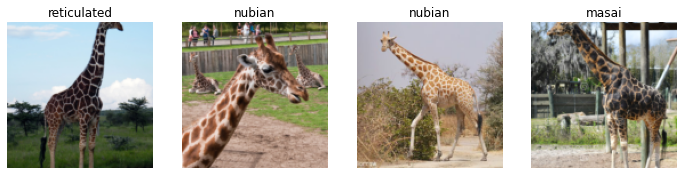

In [28]:
dls.valid.show_batch(max_n=4, nrows=1)

By default `Resize` *crops* the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:

## Training Your Model, and Using It to Clean Your Data

Time to use the same lines of code as in <<chapter_intro>> to train our bear classifier.

We don't have a lot of data for our problem (150 pictures of each sort of bear at most), so to train our model, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default `aug_transforms`:

In [37]:
giraffes = giraffes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = giraffes.dataloaders(path)

We can now create our `Learner` and fine-tune it in the usual way:

In [38]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.911730,1.097480,0.505747,00:19


epoch,train_loss,valid_loss,error_rate,time
0,1.366812,1.000137,0.494253,00:20
1,1.235747,0.870424,0.287356,00:20
2,1.085510,0.914404,0.310345,00:20
3,0.964355,0.975997,0.298851,00:20


Now let's see whether the mistakes the model is making are mainly thinking that grizzlies are teddies (that would be bad for safety!), or that grizzlies are black bears, or something else. To visualize this, we can create a *confusion matrix*:

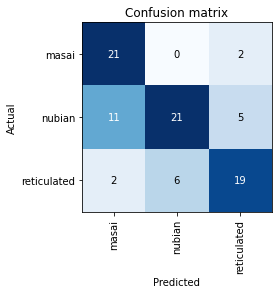

In [39]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The rows represent all the black, grizzly, and teddy bears in our dataset, respectively. The columns represent the images which the model predicted as black, grizzly, and teddy bears, respectively. Therefore, the diagonal of the matrix shows the images which were classified correctly, and the off-diagonal cells represent those which were classified incorrectly. This is one of the many ways that fastai allows you to view the results of your model. It is (of course!) calculated using the validation set. With the color-coding, the goal is to have white everywhere except the diagonal, where we want dark blue. Our bear classifier isn't making many mistakes!

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't bears at all, or are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their *loss*.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. In a couple of chapters we'll learn in depth how loss is calculated and used in the training process. For now, `plot_top_losses` shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The *probability* here is the confidence level, from zero to one, that the model has assigned to its prediction:

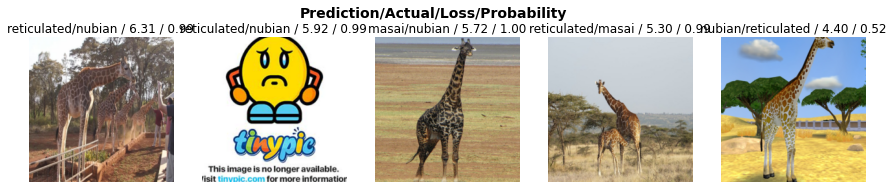

In [40]:
interp.plot_top_losses(5, nrows=1)

This output shows that the image with the highest loss is one that has been predicted as "grizzly" with high confidence. However, it's labeled (based on our Bing image search) as "black." We're not bear experts, but it sure looks to us like this label is incorrect! We should probably change its label to "grizzly."

The intuitive approach to doing data cleaning is to do it *before* you train a model. But as you've seen in this case, a model can actually help you find data issues more quickly and easily. So, we normally prefer to train a quick and simple model first, and then use it to help us with data cleaning.

fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [41]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

<img alt="Cleaner widget" width="700" src="https://github.com/fastai/fastbook/blob/master/images/att_00007.png?raw=1">

In [35]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

FileNotFoundError: ignored

We can see that amongst our "black bears" is an image that contains two bears: one grizzly, one black. So, we should choose `<Delete>` in the menu under this image. `ImageClassifierCleaner` doesn't actually do the deleting or changing of labels for you; it just returns the indices of items to change. So, for instance, to delete (`unlink`) all images selected for deletion, we would run:

```python
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
```

To move images for which we've selected a different category, we would run:

```python
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
```

> s: Cleaning the data and getting it ready for your model are two of the biggest challenges for data scientists; they say it takes 90% of their time. The fastai library aims to provide tools that make it as easy as possible.

We'll be seeing more examples of model-driven data cleaning throughout this book. Once we've cleaned up our data, we can retrain our model. Try it yourself, and see if your accuracy improves!

> note: No Need for Big Data: After cleaning the dataset using these steps, we generally are seeing 100% accuracy on this task. We even see that result when we download a lot fewer images than the 150 per class we're using here. As you can see, the common complaint that _you need massive amounts of data to do deep learning_ can be a very long way from the truth!

Now that we have trained our model, let's see how we can deploy it to be used in practice.

## Turning Your Model into an Online Application

We are now going to look at what it takes to turn this model into a working online application. We will just go as far as creating a basic working prototype; we do not have the scope in this book to teach you all the details of web application development generally.

### Using the Model for Inference

Once you've got a model you're happy with, you need to save it, so that you can then copy it over to a server where you'll use it in production. Remember that a model consists of two parts: the *architecture* and the trained *parameters*. The easiest way to save the model is to save both of these, because that way when you load a model you can be sure that you have the matching architecture and parameters. To save both parts, use the `export` method.

This method even saves the definition of how to create your `DataLoaders`. This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production. fastai automatically uses your validation set `DataLoader` for inference by default, so your data augmentation will not be applied, which is generally what you want.

When you call `export`, fastai will save a file called "export.pkl":

In [42]:
learn.export()

Let's check that the file exists, by using the `ls` method that fastai adds to Python's `Path` class:

In [43]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

You'll need this file wherever you deploy your app to. For now, let's try to create a simple app within our notebook.

When we use a model for getting predictions, instead of training, we call it *inference*. To create our inference learner from the exported file, we use `load_learner` (in this case, this isn't really necessary, since we already have a working `Learner` in our notebook; we're just doing it here so you can see the whole process end-to-end):

In [44]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']
import os
os.mkdir("images")

dest = 'images/reticulated.jpg'
download_url(ims[0], dest)

When we're doing inference, we're generally just getting predictions for one image at a time. To do this, pass a filename to `predict`:

In [46]:
learn_inf.predict('images/IMG_9115.JPG')

('masai', tensor(0), tensor([0.8081, 0.0924, 0.0996]))

This has returned three things: the predicted category in the same format you originally provided (in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the *vocab* of the `DataLoaders`; that is, the stored list of all possible categories. At inference time, you can access the `DataLoaders` as an attribute of the `Learner`:

In [47]:
learn_inf.dls.vocab

(#3) ['masai','nubian','reticulated']

We can see here that if we index into the vocab with the integer returned by `predict` then we get back "grizzly," as expected. Also, note that if we index into the list of probabilities, we see a nearly 1.00 probability that this is a grizzly.

We know how to make predictions from our saved model, so we have everything we need to start building our app. We can do it directly in a Jupyter notebook.

### Creating a Notebook App from the Model

To use our model in an application, we can simply treat the `predict` method as a regular function. Therefore, creating an app from the model can be done using any of the myriad of frameworks and techniques available to application developers.

However, most data scientists are not familiar with the world of web application development. So let's try using something that you do, at this point, know: it turns out that we can create a complete working web application using nothing but Jupyter notebooks! The two things we need to make this happen are:

- IPython widgets (ipywidgets)
- Voilà

*IPython widgets* are GUI components that bring together JavaScript and Python functionality in a web browser, and can be created and used within a Jupyter notebook. For instance, the image cleaner that we saw earlier in this chapter is entirely written with IPython widgets. However, we don't want to require users of our application to run Jupyter themselves.

That is why *Voilà* exists. It is a system for making applications consisting of IPython widgets available to end users, without them having to use Jupyter at all. Voilà is taking advantage of the fact that a notebook _already is_ a kind of web application, just a rather complex one that depends on another web application: Jupyter itself. Essentially, it helps us automatically convert the complex web application we've already implicitly made (the notebook) into a simpler, easier-to-deploy web application, which functions like a normal web application rather than like a notebook.

But we still have the advantage of developing in a notebook, so with ipywidgets, we can build up our GUI step by step. We will use this approach to create a simple image classifier. First, we need a file upload widget:

In [ ]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

<img alt="An upload button" width="159" src="https://github.com/fastai/fastbook/blob/master/images/att_00008.png?raw=1">

Now we can grab the image:

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

<img alt="Output widget representing the image" width="117" src="https://github.com/fastai/fastbook/blob/master/images/att_00009.png?raw=1">

We can use an `Output` widget to display it:

In [ ]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

<img alt="Output widget representing the image" width="117" src="https://github.com/fastai/fastbook/blob/master/images/att_00009.png?raw=1">

Then we can get our predictions:

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

and use a `Label` to display them:

In [ ]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

`Prediction: grizzly; Probability: 1.0000`

We'll need a button to do the classification. It looks exactly like the upload button:

In [ ]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

We'll also need a *click event handler*; that is, a function that will be called when it's pressed. We can just copy over the lines of code from above:

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

You can test the button now by pressing it, and you should see the image and predictions update automatically!

We can now put them all in a vertical box (`VBox`) to complete our GUI:

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

<img alt="The whole widget" width="233" src="https://github.com/fastai/fastbook/blob/master/images/att_00011.png?raw=1">

We have written all the code necessary for our app. The next step is to convert it into something we can deploy.

### Turning Your Notebook into a Real App

In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable voila —sys-prefix

Now that we have everything working in this Jupyter notebook, we can create our application. To do this, start a new notebook and add to it only the code needed to create and show the widgets that you need, and markdown for any text that you want to appear. Have a look at the *bear_classifier* notebook in the book's repo to see the simple notebook application we created.

Next, install Voilà if you haven't already, by copying these lines into a notebook cell and executing it:

    !pip install voila
    !jupyter serverextension enable voila —sys-prefix

Cells that begin with a `!` do not contain Python code, but instead contain code that is passed to your shell (bash, Windows PowerShell, etc.). If you are comfortable using the command line, which we'll discuss more later in this book, you can of course simply type these two lines (without the `!` prefix) directly into your terminal. In this case, the first line installs the `voila` library and application, and the second connects it to your existing Jupyter notebook.

Voilà runs Jupyter notebooks just like the Jupyter notebook server you are using now does, but it also does something very important: it removes all of the cell inputs, and only shows output (including ipywidgets), along with your markdown cells. So what's left is a web application! To view your notebook as a Voilà web application, replace the word "notebooks" in your browser's URL with: "voila/render". You will see the same content as your notebook, but without any of the code cells.

Of course, you don't need to use Voilà or ipywidgets. Your model is just a function you can call (`pred,pred_idx,probs = learn.predict(img)`), so you can use it with any framework, hosted on any platform. And you can take something you've prototyped in ipywidgets and Voilà and later convert it into a regular web application. We're showing you this approach in the book because we think it's a great way for data scientists and other folks that aren't web development experts to create applications from their models.

We have our app, now let's deploy it!

### Deploying your app

As you now know, you need a GPU to train nearly any useful deep learning model. So, do you need a GPU to use that model in production? No! You almost certainly *do not need a GPU to serve your model in production*. There are a few reasons for this:

- As we've seen, GPUs are only useful when they do lots of identical work in parallel. If you're doing (say) image classification, then you'll normally be classifying just one user's image at a time, and there isn't normally enough work to do in a single image to keep a GPU busy for long enough for it to be very efficient. So, a CPU will often be more cost-effective.
- An alternative could be to wait for a few users to submit their images, and then batch them up and process them all at once on a GPU. But then you're asking your users to wait, rather than getting answers straight away! And you need a high-volume site for this to be workable. If you do need this functionality, you can use a tool such as Microsoft's [ONNX Runtime](https://github.com/microsoft/onnxruntime), or [AWS Sagemaker](https://aws.amazon.com/sagemaker/)
- The complexities of dealing with GPU inference are significant. In particular, the GPU's memory will need careful manual management, and you'll need a careful queueing system to ensure you only process one batch at a time.
- There's a lot more market competition in CPU than GPU servers, as a result of which there are much cheaper options available for CPU servers.

Because of the complexity of GPU serving, many systems have sprung up to try to automate this. However, managing and running these systems is also complex, and generally requires compiling your model into a different form that's specialized for that system. It's typically preferable to avoid dealing with this complexity until/unless your app gets popular enough that it makes clear financial sense for you to do so.

For at least the initial prototype of your application, and for any hobby projects that you want to show off, you can easily host them for free. The best place and the best way to do this will vary over time, so check the [book's website](https://book.fast.ai/) for the most up-to-date recommendations. As we're writing this book in early 2020 the simplest (and free!) approach is to use [Binder](https://mybinder.org/). To publish your web app on Binder, you follow these steps:

1. Add your notebook to a [GitHub repository](http://github.com/).
2. Paste the URL of that repo into Binder's URL, as shown in <<deploy-binder>>.
3. Change the File dropdown to instead select URL.
4. In the "URL to open" field, enter `/voila/render/name.ipynb` (replacing `name` with the name of for your notebook).
5. Click the clickboard button at the bottom right to copyt the URL and paste it somewhere safe. 
6. Click Launch.

<img alt="Deploying to Binder" width="800" caption="Deploying to Binder" id="deploy-binder" src="https://github.com/fastai/fastbook/blob/master/images/att_00001.png?raw=1">

The first time you do this, Binder will take around 5 minutes to build your site. Behind the scenes, it is finding a virtual machine that can run your app, allocating storage, collecting the files needed for Jupyter, for your notebook, and for presenting your notebook as a web application.

Finally, once it has started the app running, it will navigate your browser to your new web app. You can share the URL you copied to allow others to access your app as well.

For other (both free and paid) options for deploying your web app, be sure to take a look at the [book's website](https://book.fast.ai/).

You may well want to deploy your application onto mobile devices, or edge devices such as a Raspberry Pi. There are a lot of libraries and frameworks that allow you to integrate a model directly into a mobile application. However, these approaches tend to require a lot of extra steps and boilerplate, and do not always support all the PyTorch and fastai layers that your model might use. In addition, the work you do will depend on what kind of mobile devices you are targeting for deployment—you might need to do some work to run on iOS devices, different work to run on newer Android devices, different work for older Android devices, etc. Instead, we recommend wherever possible that you deploy the model itself to a server, and have your mobile or edge application connect to it as a web service.

There are quite a few upsides to this approach. The initial installation is easier, because you only have to deploy a small GUI application, which connects to the server to do all the heavy lifting. More importantly perhaps, upgrades of that core logic can happen on your server, rather than needing to be distributed to all of your users. Your server will have a lot more memory and processing capacity than most edge devices, and it is far easier to scale those resources if your model becomes more demanding. The hardware that you will have on a server is also going to be more standard and more easily supported by fastai and PyTorch, so you don't have to compile your model into a different form.

There are downsides too, of course. Your application will require a network connection, and there will be some latency each time the model is called. (It takes a while for a neural network model to run anyway, so this additional network latency may not make a big difference to your users in practice. In fact, since you can use better hardware on the server, the overall latency may even be less than if it were running locally!) Also, if your application uses sensitive data then your users may be concerned about an approach which sends that data to a remote server, so sometimes privacy considerations will mean that you need to run the model on the edge device (it may be possible to avoid this by having an *on-premise* server, such as inside a company's firewall). Managing the complexity and scaling the server can create additional overhead too, whereas if your model runs on the edge devices then each user is bringing their own compute resources, which leads to easier scaling with an increasing number of users (also known as *horizontal scaling*).

> A: I've had a chance to see up close how the mobile ML landscape is changing in my work. We offer an iPhone app that depends on computer vision, and for years we ran our own computer vision models in the cloud. This was the only way to do it then since those models needed significant memory and compute resources and took minutes to process inputs. This approach required building not only the models (fun!) but also the infrastructure to ensure a certain number of "compute worker machines" were absolutely always running (scary), that more machines would automatically come online if traffic increased, that there was stable storage for large inputs and outputs, that the iOS app could know and tell the user how their job was doing, etc. Nowadays Apple provides APIs for converting models to run efficiently on device and most iOS devices have dedicated ML hardware, so that's the strategy we use for our newer models. It's still not easy but in our case it's worth it, for a faster user experience and to worry less about servers. What works for you will depend, realistically, on the user experience you're trying to create and what you personally find is easy to do. If you really know how to run servers, do it. If you really know how to build native mobile apps, do that. There are many roads up the hill.

Overall, we'd recommend using a simple CPU-based server approach where possible, for as long as you can get away with it. If you're lucky enough to have a very successful application, then you'll be able to justify the investment in more complex deployment approaches at that time.

Congratulations, you have successfully built a deep learning model and deployed it! Now is a good time to take a pause and think about what could go wrong.

## How to Avoid Disaster

In practice, a deep learning model will be just one piece of a much bigger system. As we discussed at the start of this chapter, a data product requires thinking about the entire end-to-end process, from conception to use in production. In this book, we can't hope to cover all the complexity of managing deployed data products, such as managing multiple versions of models, A/B testing, canarying, refreshing the data (should we just grow and grow our datasets all the time, or should we regularly remove some of the old data?), handling data labeling, monitoring all this, detecting model rot, and so forth. In this section we will give an overview of some of the most important issues to consider; for a more detailed discussion of deployment issues we refer to you to the excellent [Building Machine Learning Powered Applications](http://shop.oreilly.com/product/0636920215912.do) by Emmanuel Ameisen (O'Reilly)

One of the biggest issues to consider is that understanding and testing the behavior of a deep learning model is much more difficult than with most other code you write. With normal software development you can analyze the exact steps that the software is taking, and carefully study which of these steps match the desired behavior that you are trying to create. But with a neural network the behavior emerges from the model's attempt to match the training data, rather than being exactly defined.

This can result in disaster! For instance, let's say we really were rolling out a bear detection system that will be attached to video cameras around campsites in national parks, and will warn campers of incoming bears. If we used a model trained with the dataset we downloaded there would be all kinds of problems in practice, such as:

- Working with video data instead of images
- Handling nighttime images, which may not appear in this dataset
- Dealing with low-resolution camera images
- Ensuring results are returned fast enough to be useful in practice
- Recognizing bears in positions that are rarely seen in photos that people post online (for example from behind, partially covered by bushes, or when a long way away from the camera)

A big part of the issue is that the kinds of photos that people are most likely to upload to the internet are the kinds of photos that do a good job of clearly and artistically displaying their subject matter—which isn't the kind of input this system is going to be getting. So, we may need to do a lot of our own data collection and labelling to create a useful system.

This is just one example of the more general problem of *out-of-domain* data. That is to say, there may be data that our model sees in production which is very different to what it saw during training. There isn't really a complete technical solution to this problem; instead, we have to be careful about our approach to rolling out the technology.

There are other reasons we need to be careful too. One very common problem is *domain shift*, where the type of data that our model sees changes over time. For instance, an insurance company may use a deep learning model as part of its pricing and risk algorithm, but over time the types of customers that the company attracts, and the types of risks they represent, may change so much that the original training data is no longer relevant.

Out-of-domain data and domain shift are examples of a larger problem: that you can never fully understand the entire behaviour of your neural network. They have far too many parameters to be able to analytically understand all of their possible behaviors. This is the natural downside of their best feature—their flexibility, which enables them to solve complex problems where we may not even be able to fully specify our preferred solution approaches. The good news, however, is that there are ways to mitigate these risks using a carefully thought-out process. The details of this will vary depending on the details of the problem you are solving, but we will attempt to lay out here a high-level approach, summarized in <<deploy_process>>, which we hope will provide useful guidance.

<img alt="Deployment process" width="500" caption="Deployment process" id="deploy_process" src="https://github.com/fastai/fastbook/blob/master/images/att_00061.png?raw=1">

Where possible, the first step is to use an entirely manual process, with your deep learning model approach running in parallel but not being used directly to drive any actions. The humans involved in the manual process should look at the deep learning outputs and check whether they make sense. For instance, with our bear classifier a park ranger could have a screen displaying video feeds from all the cameras, with any possible bear sightings simply highlighted in red. The park ranger would still be expected to be just as alert as before the model was deployed; the model is simply helping to check for problems at this point.

The second step is to try to limit the scope of the model, and have it carefully supervised by people. For instance, do a small geographically and time-constrained trial of the model-driven approach. Rather than rolling our bear classifier out in every national park throughout the country, we could pick a single observation post, for a one-week period, and have a park ranger check each alert before it goes out.

Then, gradually increase the scope of your rollout. As you do so, ensure that you have really good reporting systems in place, to make sure that you are aware of any significant changes to the actions being taken compared to your manual process. For instance, if the number of bear alerts doubles or halves after rollout of the new system in some location, we should be very concerned. Try to think about all the ways in which your system could go wrong, and then think about what measure or report or picture could reflect that problem, and ensure that your regular reporting includes that information.

> J: I started a company 20 years ago called _Optimal Decisions_ that used machine learning and optimization to help giant insurance companies set their pricing, impacting tens of billions of dollars of risks. We used the approaches described here to manage the potential downsides of something going wrong. Also, before we worked with our clients to put anything in production, we tried to simulate the impact by testing the end-to-end system on their previous year's data. It was always quite a nerve-wracking process, putting these new algorithms into production, but every rollout was successful.

### Unforeseen Consequences and Feedback Loops

One of the biggest challenges in rolling out a model is that your model may change the behaviour of the system it is a part of. For instance, consider a "predictive policing" algorithm that predicts more crime in certain neighborhoods, causing more police officers to be sent to those neighborhoods, which can result in more crimes being recorded in those neighborhoods, and so on. In the Royal Statistical Society paper ["To Predict and Serve?"](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/j.1740-9713.2016.00960.x), Kristian Lum and William Isaac observe that: "predictive policing is aptly named: it is predicting future policing, not future crime."

Part of the issue in this case is that in the presence of bias (which we'll discuss in depth in the next chapter), *feedback loops* can result in negative implications of that bias getting worse and worse. For instance, there are concerns that this is already happening in the US, where there is significant bias in arrest rates on racial grounds. [According to the ACLU](https://www.aclu.org/issues/smart-justice/sentencing-reform/war-marijuana-black-and-white), "despite roughly equal usage rates, Blacks are 3.73 times more likely than whites to be arrested for marijuana." The impact of this bias, along with the rollout of predictive policing algorithms in many parts of the US, led Bärí Williams to [write in the *New York Times*](https://www.nytimes.com/2017/12/02/opinion/sunday/intelligent-policing-and-my-innocent-children.html): "The same technology that’s the source of so much excitement in my career is being used in law enforcement in ways that could mean that in the coming years, my son, who is 7 now, is more likely to be profiled or arrested—or worse—for no reason other than his race and where we live."

A helpful exercise prior to rolling out a significant machine learning system is to consider this question: "What would happen if it went really, really well?" In other words, what if the predictive power was extremely high, and its ability to influence behavior was extremely significant? In that case, who would be most impacted? What would the most extreme results potentially look like? How would you know what was really going on?

Such a thought exercise might help you to construct a more careful rollout plan, with ongoing monitoring systems and human oversight. Of course, human oversight isn't useful if it isn't listened to, so make sure that there are reliable and resilient communication channels so that the right people will be aware of issues, and will have the power to fix them.

## Get Writing!

One of the things our students have found most helpful to solidify their understanding of this material is to write it down. There is no better test of your understanding of a topic than attempting to teach it to somebody else. This is helpful even if you never show your writing to anybody—but it's even better if you share it! So we recommend that, if you haven't already, you start a blog. Now that you've completed Chapter 2 and have learned how to train and deploy models, you're well placed to write your first blog post about your deep learning journey. What's surprised you? What opportunities do you see for deep learning in your field? What obstacles do you see?

Rachel Thomas, cofounder of fast.ai, wrote in the article ["Why You (Yes, You) Should Blog"](https://medium.com/@racheltho/why-you-yes-you-should-blog-7d2544ac1045):

```asciidoc
____
The top advice I would give my younger self would be to start blogging sooner. Here are some reasons to blog:

* It’s like a resume, only better. I know of a few people who have had blog posts lead to job offers!
* Helps you learn. Organizing knowledge always helps me synthesize my own ideas. One of the tests of whether you understand something is whether you can explain it to someone else. A blog post is a great way to do that.
* I’ve gotten invitations to conferences and invitations to speak from my blog posts. I was invited to the TensorFlow Dev Summit (which was awesome!) for writing a blog post about how I don’t like TensorFlow.
* Meet new people. I’ve met several people who have responded to blog posts I wrote.
* Saves time. Any time you answer a question multiple times through email, you should turn it into a blog post, which makes it easier for you to share the next time someone asks.
____
```

Perhaps her most important tip is this: 

> : You are best positioned to help people one step behind you. The material is still fresh in your mind. Many experts have forgotten what it was like to be a beginner (or an intermediate) and have forgotten why the topic is hard to understand when you first hear it. The context of your particular background, your particular style, and your knowledge level will give a different twist to what you’re writing about.

We've provided full details on how to set up a blog in <<appendix_blog>>. If you don't have a blog already, take a look at that now, because we've got a really great approach set up for you to start blogging for free, with no ads—and you can even use Jupyter Notebook!

## Questionnaire

1. Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.
1. Where do text models currently have a major deficiency?
1. What are possible negative societal implications of text generation models?
1. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?
1. What kind of tabular data is deep learning particularly good at?
1. What's a key downside of directly using a deep learning model for recommendation systems?
1. What are the steps of the Drivetrain Approach?
1. How do the steps of the Drivetrain Approach map to a recommendation system?
1. Create an image recognition model using data you curate, and deploy it on the web.
1. What is `DataLoaders`?
1. What four things do we need to tell fastai to create `DataLoaders`?
1. What does the `splitter` parameter to `DataBlock` do?
1. How do we ensure a random split always gives the same validation set?
1. What letters are often used to signify the independent and dependent variables?
1. What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?
1. What is data augmentation? Why is it needed?
1. What is the difference between `item_tfms` and `batch_tfms`?
1. What is a confusion matrix?
1. What does `export` save?
1. What is it called when we use a model for getting predictions, instead of training?
1. What are IPython widgets?
1. When might you want to use CPU for deployment? When might GPU be better?
1. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?
1. What are three examples of problems that could occur when rolling out a bear warning system in practice?
1. What is "out-of-domain data"?
1. What is "domain shift"?
1. What are the three steps in the deployment process?

### Further Research

1. Consider how the Drivetrain Approach maps to a project or problem you're interested in.
1. When might it be best to avoid certain types of data augmentation?
1. For a project you're interested in applying deep learning to, consider the thought experiment "What would happen if it went really, really well?"
1. Start a blog, and write your first blog post. For instance, write about what you think deep learning might be useful for in a domain you're interested in.